# Usage of Keras for image_classification


* configure random transformations and normalization operations to be done on your image data during training
* instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers
from keras.layers.normalization import BatchNormalization

import numpy as np
seed = 13
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
## use only 30 % of the memory
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

In [3]:
# imports to display the svg image of the network
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt

import pydot
import graphviz

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [17]:
batch_size = 32

# train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, width_shift_range=0.1,
                                  height_shift_range=0.1,zoom_range=0.1)
# train_datagen = ImageDataGenerator(rotation_range=40,width_shift_range=0.2,
#     height_shift_range=0.2,rescale=1./255,shear_range=0.2,
#     zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

# only rescaling augmentation for test samples
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_dir = '../xraydata/processed/train'
test_dir = '../xraydata/processed/test'

In [19]:
# this is a generaotr that will read pictures 
# found in sub folders of 'data/train',
# and indefinitely generate batches of augmented image data
train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(100,50),
                shuffle=True,
                color_mode='grayscale',
                batch_size=batch_size,
                class_mode='categorical') # since we use categoricalentropy loss

Found 400 images belonging to 5 classes.


In [20]:
# this is a similar generatr, for validation/test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100,50),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical')

Found 100 images belonging to 5 classes.


# inspirational architectures taken from 
[brain_segmentation](https://github.com/naldeborgh7575/brain_segmentation/blob/master/code/Segmentation_Models.py)
[image_classification](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)



In [39]:
nb_train_samples = 400
nb_test_samples = 100

model = Sequential()

model.add(Conv2D(64, (3,3), input_shape=(100,50,1), padding='same',
                 kernel_regularizer=regularizers.l2(0.001),activity_regularizer=regularizers.l1(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3,3), padding='same'))#, kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(5))
model.add(Activation('softmax'))

from keras.optimizers import Adam
          
adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

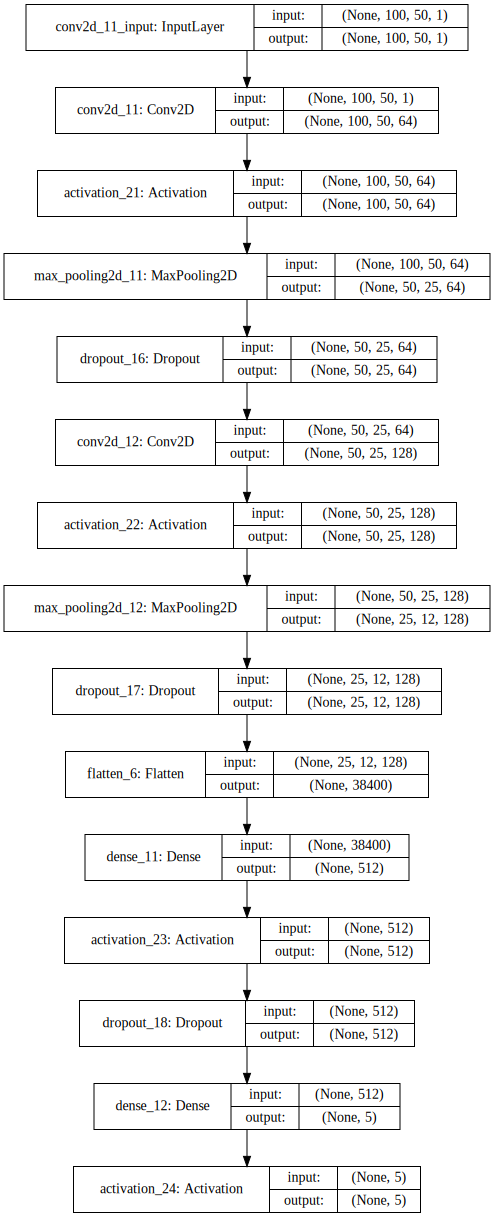

In [40]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 100, 50, 64)       640       
_________________________________________________________________
activation_21 (Activation)   (None, 100, 50, 64)       0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 50, 25, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 50, 25, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 25, 128)       73856     
_________________________________________________________________
activation_22 (Activation)   (None, 50, 25, 128)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 12, 128)       0         
__________

In [42]:
run_count += 1
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir="./summary/run_{}".format(run_count), 
                         histogram_freq=2, write_graph=True, 
                         write_images=True)

model.fit_generator(train_generator,
                   steps_per_epoch=nb_train_samples // batch_size,
                   epochs=120,
                   validation_data=test_generator,
                   validation_steps=nb_test_samples // batch_size,
                   callbacks=[tbCallBack])

model.save_weights('first_try.h5')
model.save('my_model.h5')

INFO:tensorflow:Summary name conv2d_11/kernel:0 is illegal; using conv2d_11/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_11/kernel:0 is illegal; using conv2d_11/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_11/bias:0 is illegal; using conv2d_11/bias_0 instead.
INFO:tensorflow:Summary name conv2d_11/bias:0 is illegal; using conv2d_11/bias_0 instead.
INFO:tensorflow:Summary name conv2d_12/kernel:0 is illegal; using conv2d_12/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_12/bias:0 is illegal; using conv2d_12/bias_0 instead.
INFO:tensorflow:Summary name conv2d_12/bias:0 is illegal; using conv2d_12/bias_0 instead.
INFO:tensorflow:Summary name dense_11/kernel:0 is illegal; using dense_11/kernel_0 instead.
INFO:tensorflow:Summary name dense_11/kernel:0 is illegal; using dense_11/kernel_0 instead.
INFO:tensorflow:Summary name dense_11/bias:0 is illegal; using dense_11/bias_0 instead.
INFO:tensorflow:Summary name dense_11/bias:0 is illegal; using dense_11/bias_0 instead

12/12 [==============================] - 0s - loss: 45.8738 - acc: 0.7478 - val_loss: 48.4888 - val_acc: 0.6765
Epoch 56/120
12/12 [==============================] - 0s - loss: 44.9524 - acc: 0.7763 - val_loss: 44.5886 - val_acc: 0.7059
Epoch 57/120
12/12 [==============================] - 0s - loss: 43.5651 - acc: 0.7940 - val_loss: 45.1079 - val_acc: 0.6765
Epoch 58/120
12/12 [==============================] - 0s - loss: 44.9681 - acc: 0.7785 - val_loss: 47.6512 - val_acc: 0.6912
Epoch 59/120
12/12 [==============================] - 0s - loss: 43.3103 - acc: 0.7966 - val_loss: 46.5024 - val_acc: 0.7353
Epoch 60/120
12/12 [==============================] - 0s - loss: 43.5564 - acc: 0.7626 - val_loss: 46.3827 - val_acc: 0.7353
Epoch 61/120
12/12 [==============================] - 0s - loss: 42.3657 - acc: 0.7787 - val_loss: 46.6385 - val_acc: 0.7353
Epoch 62/120
12/12 [==============================] - 0s - loss: 42.8920 - acc: 0.7657 - val_loss: 45.9975 - val_acc: 0.6912
Epoch 63/120


12/12 [==============================] - 0s - loss: 25.7919 - acc: 0.8282 - val_loss: 29.2026 - val_acc: 0.8088


In [47]:
import scipy.misc
image = scipy.misc.imread('../xraydata/blackandwhitecar.jpeg', mode='L')
#image = scipy.misc.imread('../xraydata/x_ray_heart_by_mmattes.jpg', mode='L')
#image = scipy.misc.imread('../xraydata/processed/test/Body/Body_47524821.jpeg',mode='L')
image = scipy.misc.imresize(image, (100,50))
image = image / 255
image = np.expand_dims(image, axis=2)

model.save('80_mf.h5')
image = image.reshape((1,) + image.shape)
model.predict_proba(image, verbose=1, batch_size=1)

1/1 [==============================] - 0s


array([[  9.55800056e-01,   9.19995946e-04,   7.95655724e-05,
          2.66963220e-03,   4.05308120e-02]], dtype=float32)

In [ ]:
model.predict(image)

In [44]:
train_generator.class_indices

{'Body': 0,
 'Head-Neck': 1,
 'Lower-Limb': 2,
 'True-Negative': 3,
 'Upper-Limb': 4}

In [48]:
image = scipy.misc.imread('../xraydata/processed/test/Lower-Limb/Lower-Limb_85026021.jpeg',mode='L')
print(image.shape)
image = np.expand_dims(image, axis=2)
print(image.shape)
image = np.tile(image, (1, 3)) 
print(image.shape)

(100, 50)
(100, 50, 1)
(100, 50, 3)
